# Session-3: Face Alignment using 5-Point Landmark detector by DLIB

In the 5-point model, the landmark points consist of 2 points at the corners of the eye; for each eye and one point on the nose-tip

In [3]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import torch

# check the allocation machine
isCuda = torch.cuda.is_available()
machine = torch.cuda.get_device_properties(0) if isCuda else 'cpu'
print("Assigned Machine: ", machine)
device = torch.device('cuda:0' if isCuda else 'cpu')
print(f"cuda avaiable: {isCuda}, Device: {device}")

Assigned Machine:  _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
cuda avaiable: True, Device: cuda:0


In [4]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session3/notebooks/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session3/notebooks


In [6]:
'''
Note: 
1. faceBlendCommon.py was using function from cv2 version 3 which are deprecated in higher version. 
2. similarityTransform fxn in  faceBlendCommon.py is modified where cv2.estimateRigidTransform is replace with cv2.estimateAffine2D to support cv version 4
'''

'\nNote: \n1. faceBlendCommon.py was using function from cv2 version 3 which are deprecated in higher version. \n2. similarityTransform fxn in  faceBlendCommon.py is modified where cv2.estimateRigidTransform is replace with cv2.estimateAffine2D to support cv version 4\n'

In [8]:
# Import standard packages
import dlib
import numpy as np
import faceBlendCommon as fbc

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
print(f'dlib: {dlib.__version__}')
print(f'cv2: {cv2.__version__}')

dlib: 19.18.0
cv2: 4.1.2


In [10]:
# To autoreload all te custom files when modified
import autoreload
%load_ext autoreload
%autoreload

In [15]:
# Landmark model location
DATA_PATH = './test_images'
RESULTS_PATH = './results'
MODEL_PATH = './predictor'
PREDICTOR_PATH = f'{MODEL_PATH}/shape_predictor_5_face_landmarks.dat'

In [16]:
# Download landmarks data file
if os.path.exists(PREDICTOR_PATH)==False:
  !wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
  !bzip2 -dk shape_predictor_5_face_landmarks.dat.bz2
else:
  print(f'model file {PREDICTOR_PATH} already exists..')

model file ./predictor/shape_predictor_5_face_landmarks.dat already exists..


In [17]:
# Initialize the face detector
faceDetector = dlib.get_frontal_face_detector()

In [18]:
# Initialize the Landmark Predictor (a.k.a. shape predictor). The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

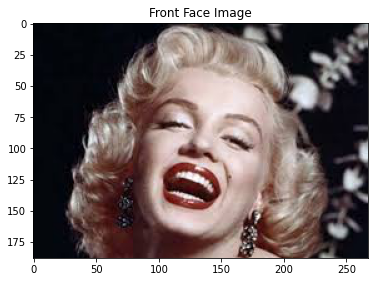

In [19]:
import PIL

# Read image
imageFilename = f'{DATA_PATH}/face.jpg'
#im = cv2.imread(imageFilename)
#plt.imshow(im[:,:,::-1])

im = PIL.Image.open(imageFilename)
im = np.array(im)

plt.imshow(im)
plt.title('Front Face Image')
plt.show()

In [20]:
im.shape

(188, 268, 3)

In [21]:
# Detect Landmark
points = fbc.getLandmarks(faceDetector, landmarkDetector, im)
points = np.array(points)

# Convert image to floating point in the range 0 to 1
im = np.float32(im)/255.0

In [22]:
# Specify the size of aligned face image. Compute the normalized image by using the similarity transform

# Dimension of output Image
h = im.shape[0] # 600
w = im.shape[1] # 600

# Normalize the image to output coordinates
imNorm, points = fbc.normalizeImagesAndLandmarks((h,w), im, points)
imNorm = np.uint8(imNorm*255)

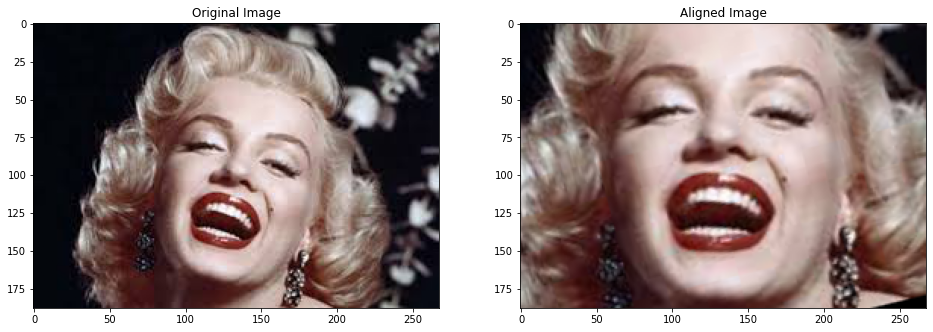

In [23]:
# Display the Result
plt.figure(figsize = (16,8)); 
plt.subplot(121); plt.imshow(im); plt.axis('on'); plt.title('Original Image');
plt.subplot(122); plt.imshow(imNorm); plt.axis('on');  plt.title('Aligned Image');
plt.savefig(f'{RESULTS_PATH}/aligned_face.jpg')


### Function to convert numpy image into base64 for transferring over network and displaying on web-page using Java script

In [24]:
from PIL import Image
import io
import base64

def img_to_base64(img):
    img = Image.fromarray(img, 'RGB') 
    buffer = io.BytesIO()
    img.save(buffer,format="JPEG")
    myimage = buffer.getvalue()                     
    img_str = f"data:image/jpeg;base64,{base64.b64encode(myimage).decode()}"
    return img_str

img_str = img_to_base64(imNorm)

''
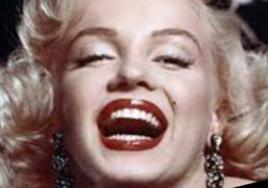

In [25]:
img_str